In [33]:
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
RANDOM_STATE = 42


In [34]:
df = pd.read_csv("Datafiniti_Amazon_Reviews.csv") 
print("Rows, Columns:", df.shape)
display(df.head(3))


Rows, Columns: (28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."


In [35]:
df.isnull().sum()

id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              0
reviews.username           5
sourceURLs                 0
dtype: int64

In [45]:
nltk_stopwords = set(stopwords.words('english'))
negation_words = {"not", "no", "nor", "n't", "don't", "didn't", "cant", "can't", "never", "none"}
custom_stopwords = nltk_stopwords - negation_words
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9'\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['cleaned_review'] = df['reviews.text'].apply(clean_text)
display(df[['reviews.text', 'cleaned_review']].head(3))


,reviews.text,cleaned_review
0,I order 3 of them and one of the item is bad q...,order 3 one item bad quality missing backup sp...
1,Bulk is always the less expensive way to go fo...,bulk always less expensive way go product like
2,Well they are not Duracell but for the price i...,well not duracell price happy


In [46]:
print("reviews.text missing:", df['reviews.text'].isnull().sum())
print("reviews.rating missing:", df['reviews.rating'].isnull().sum())
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)
df.reset_index(drop=True, inplace=True)


reviews.text missing: 0
reviews.rating missing: 0


In [47]:
negation_words_list = list(negation_words)

def extract_numeric_features(df_in):
    res = pd.DataFrame()
    text = df_in['reviews.text'].astype(str)
    clean = df_in['cleaned_review'].astype(str)

    res['num_chars'] = text.apply(len)
    res['num_tokens'] = clean.apply(lambda s: len(s.split()))
    res['exclamation_count'] = text.str.count('!')
    res['question_count'] = text.str.count(r'\?')
    res['negation_count'] = text.str.count('|'.join(negation_words_list))
    res['upper_word_count'] = text.apply(lambda s: sum(1 for w in s.split() if w.isupper()))
    res['avg_word_len'] = res['num_chars'] / (res['num_tokens'] + 1)
    return res

numeric_df = extract_numeric_features(df)
display(numeric_df.describe().T)


,count,mean,std,min,25%,50%,75%,max
num_chars,28332.0,137.517118,199.877736,1.0,54.000000,87.000000,162.000000,8351.0
num_tokens,28332.0,13.541049,18.739796,0.0,5.000000,9.000000,16.000000,731.0
exclamation_count,28332.0,0.325992,1.253073,0.0,0.000000,0.000000,0.000000,105.0
question_count,28332.0,0.005789,0.112576,0.0,0.000000,0.000000,0.000000,5.0
negation_count,28332.0,0.494564,1.101502,0.0,0.000000,0.000000,1.000000,35.0
upper_word_count,28332.0,0.932338,2.146527,0.0,0.000000,0.000000,1.000000,49.0
avg_word_len,28332.0,8.624564,2.225392,0.5,7.470588,8.888889,10.066667,56.0


In [48]:
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)

In [49]:
X = df['cleaned_review']
y = df['sentiment']


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


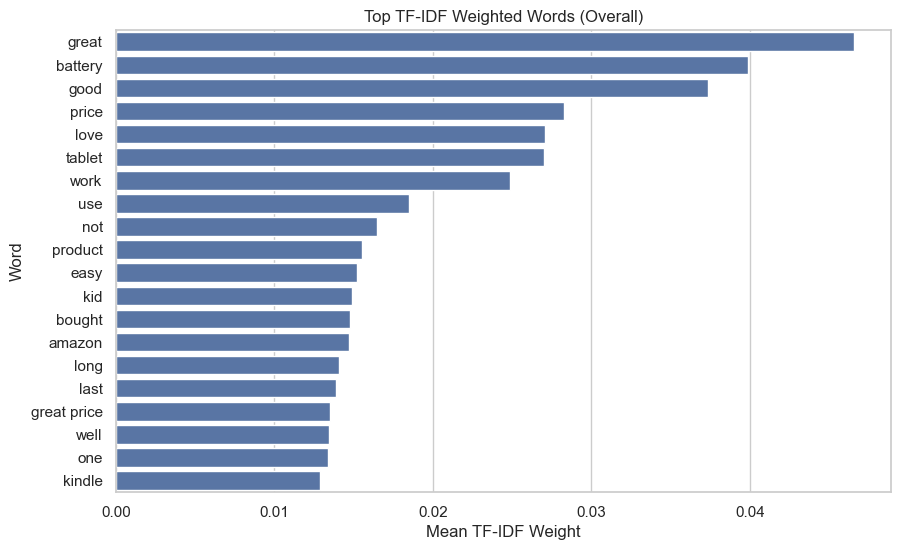

In [52]:
feature_names = np.array(tfidf.get_feature_names_out())

mean_tfidf = X_train_tfidf.mean(axis=0).A1

topn = 20
top_indices = mean_tfidf.argsort()[::-1][:topn]

top_words = feature_names[top_indices]
top_weights = mean_tfidf[top_indices]

plt.figure(figsize=(10,6))
sns.barplot(x=top_weights, y=top_words)
plt.title("Top TF-IDF Weighted Words (Overall)")
plt.xlabel("Mean TF-IDF Weight")
plt.ylabel("Word")
plt.show()


In [53]:
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'negative' if x in [1, 2] else 'positive')
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

print(df['sentiment'].value_counts())


sentiment
positive    26751
negative     1581
Name: count, dtype: int64


C:\Users\i9440\AppData\Local\Temp\ipykernel_12200\2661126019.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


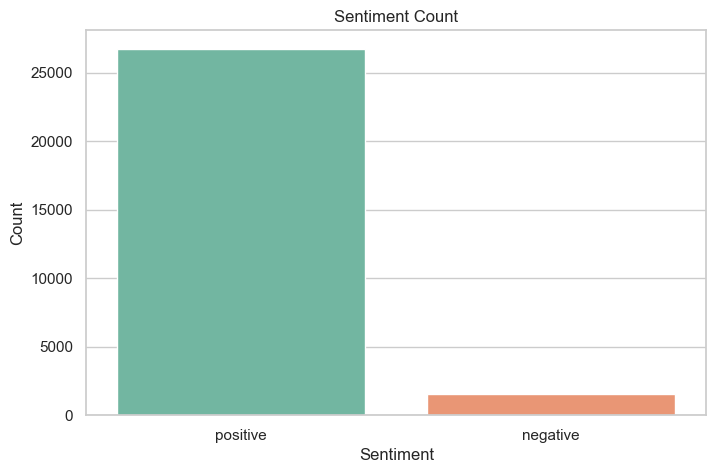

C:\Users\i9440\AppData\Local\Temp\ipykernel_12200\2661126019.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='reviews.rating', palette='viridis')


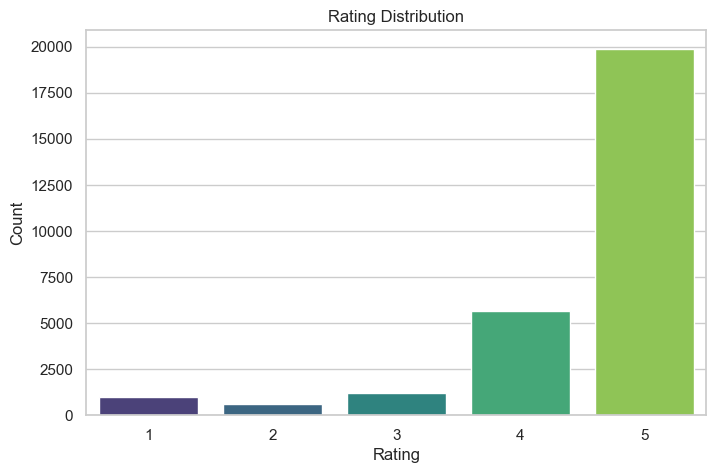

In [54]:
plt.figure()
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

plt.figure()
sns.countplot(data=df, x='reviews.rating', palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [55]:
from sklearn.utils import resample
df_negative = df[df['label'] == 0]
df_positive = df[df['label'] == 1]

if len(df_positive) > len(df_negative):
    df_positive_down = resample(df_positive,
                                replace=False,
                                n_samples=len(df_negative),
                                random_state=RANDOM_STATE)
    df_balanced = pd.concat([df_negative, df_positive_down])
else:
    df_negative_down = resample(df_negative,
                                replace=False,
                                n_samples=len(df_positive),
                                random_state=RANDOM_STATE)
    df_balanced = pd.concat([df_positive, df_negative_down])

df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Balanced dataset shape:", df_balanced.shape)
print(df_balanced['sentiment'].value_counts())


Balanced dataset shape: (3162, 27)
sentiment
negative    1581
positive    1581
Name: count, dtype: int64


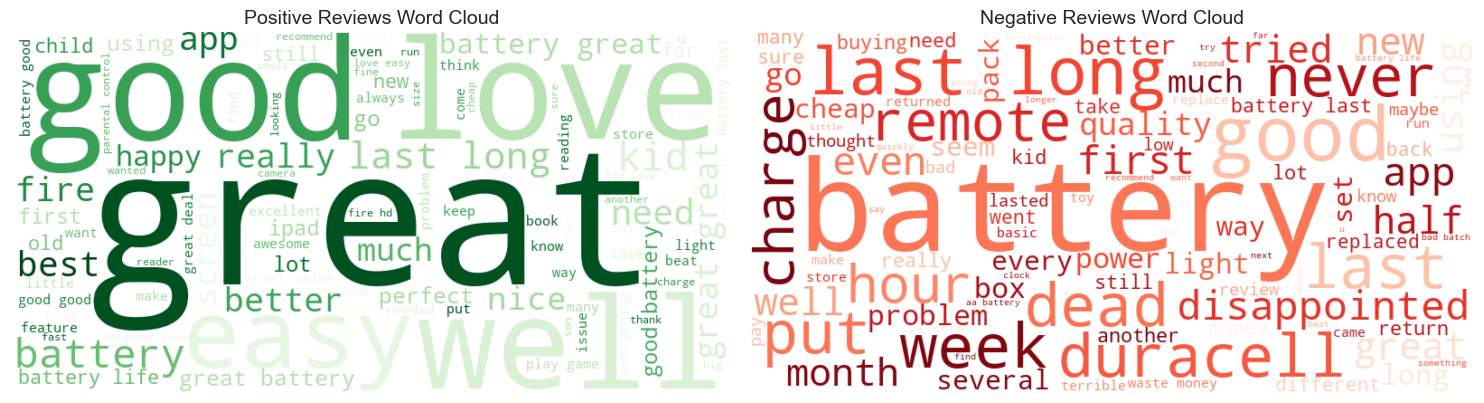

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

neutral_words = {
    "amazon", "tablet", "kindle", "product", "device", "use", "used",
    "buy", "bought", "purchase", "purchased", "item", "got", "get",
    "one", "two", "day", "year", "time", "work", "working",
    "brand", "thing", "name", "price", "order", "received"
}

# Combine with your custom stopwords (keep negations)
filtered_stopwords = custom_stopwords.union(neutral_words)

# --- Step 2: Filter text to remove neutral words ---
def remove_neutral_words(text):
    tokens = [w for w in text.split() if w not in filtered_stopwords]
    return " ".join(tokens)

df['filtered_review'] = df['cleaned_review'].apply(remove_neutral_words)

# --- Step 3: Separate by sentiment ---
positive_reviews = df[df['sentiment'] == 'positive']['filtered_review']
negative_reviews = df[df['sentiment'] == 'negative']['filtered_review']

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# --- Step 4: Generate improved word clouds ---
positive_wc = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Greens',
    max_words=100,
    min_font_size=10
).generate(positive_text)

negative_wc = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
    min_font_size=10
).generate(negative_text)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud", fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud", fontsize=14)

plt.tight_layout()
plt.show()


In [57]:
X = df_balanced['cleaned_review']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)


TF-IDF shape (train): (2529, 5000)


In [58]:
df_balanced['review_length'] = df_balanced['cleaned_review'].apply(len)
df_balanced['word_count'] = df_balanced['cleaned_review'].apply(lambda x: len(x.split()))

from textblob import TextBlob
df_balanced['polarity'] = df_balanced['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

df_balanced[['cleaned_review', 'review_length', 'word_count', 'polarity']].head()


,cleaned_review,review_length,word_count,polarity
0,one star give zero star half box dead one work...,80,16,-0.122222
1,died quick,10,2,0.333333
2,not buy leaked within one recharge battery cor...,136,22,-0.800000
3,super slow not decent quality would not buy an...,93,16,-0.016667
4,battery short life long time fan amazon com fi...,208,33,0.000000


In [59]:
def evaluate_model(model, X_test_vec, y_test, model_name="Model"):
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} Results ===")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['neg','pos'], yticklabels=['neg','pos'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return acc, y_pred


=== Logistic Regression Results ===
Accuracy: 0.9162717219589257
Classification Report:
               precision    recall  f1-score   support

           0     0.9000    0.9369    0.9181       317
           1     0.9340    0.8956    0.9144       316

    accuracy                         0.9163       633
   macro avg     0.9170    0.9162    0.9162       633
weighted avg     0.9170    0.9163    0.9162       633



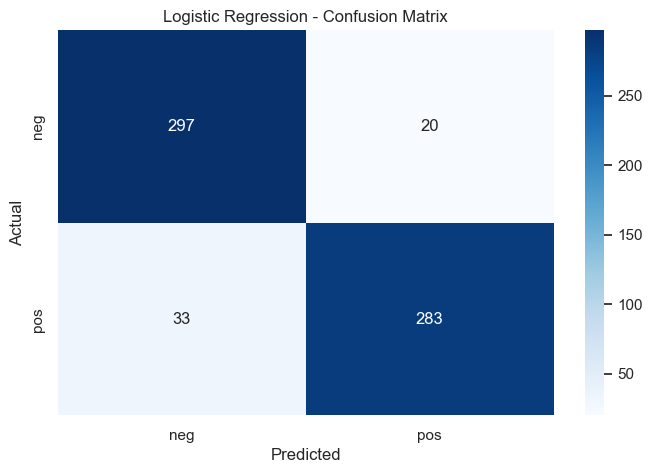

In [60]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_tfidf, y_train)
lr_acc, lr_pred = evaluate_model(lr, X_test_tfidf, y_test, model_name="Logistic Regression")


=== Multinomial Naive Bayes Results ===
Accuracy: 0.8941548183254344
Classification Report:
               precision    recall  f1-score   support

           0     0.9058    0.8801    0.8928       317
           1     0.8831    0.9082    0.8955       316

    accuracy                         0.8942       633
   macro avg     0.8945    0.8942    0.8941       633
weighted avg     0.8945    0.8942    0.8941       633



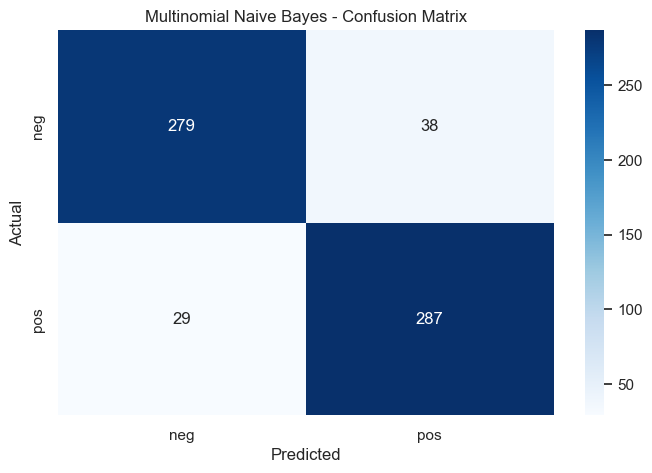

In [61]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_acc, nb_pred = evaluate_model(nb, X_test_tfidf, y_test, model_name="Multinomial Naive Bayes")


=== Linear SVC Results ===
Accuracy: 0.9225908372827805
Classification Report:
               precision    recall  f1-score   support

           0     0.9187    0.9274    0.9231       317
           1     0.9265    0.9177    0.9221       316

    accuracy                         0.9226       633
   macro avg     0.9226    0.9226    0.9226       633
weighted avg     0.9226    0.9226    0.9226       633



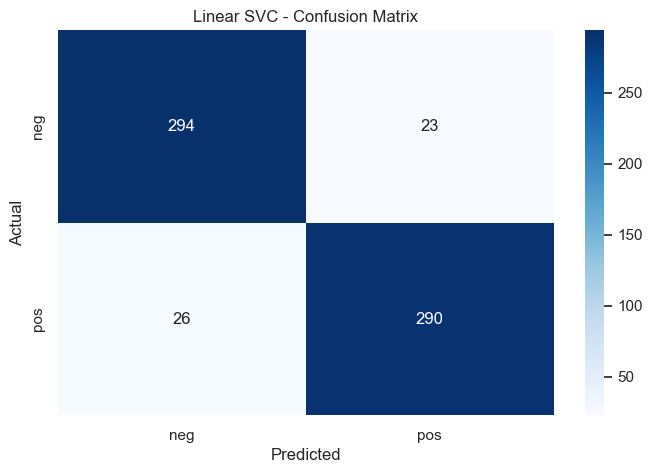

In [62]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc.fit(X_train_tfidf, y_train)
svc_acc, svc_pred = evaluate_model(svc, X_test_tfidf, y_test, model_name="Linear SVC")

,Model,Accuracy
0,LogisticRegression,0.916272
1,MultinomialNB,0.894155
2,LinearSVC,0.922591


C:\Users\i9440\AppData\Local\Temp\ipykernel_12200\4178904140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='Set2')


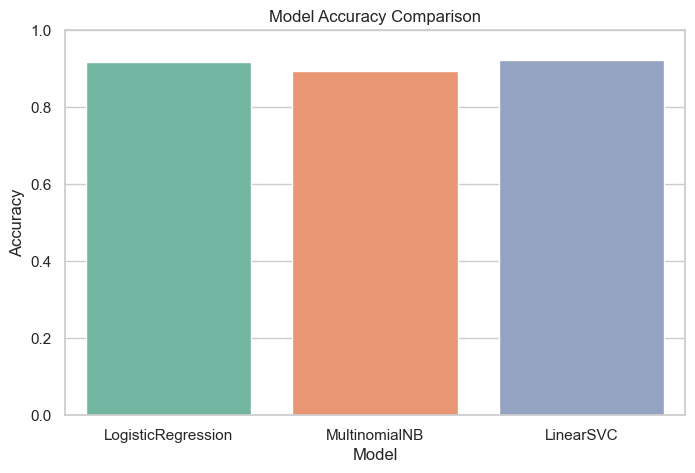

In [63]:
results_df = pd.DataFrame({
    "Model": ["LogisticRegression", "MultinomialNB", "LinearSVC"],
    "Accuracy": [lr_acc, nb_acc, svc_acc]
})
display(results_df)
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='Set2')
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.show()

In [64]:
joblib.dump(svc, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Saved svm_model.pkl and tfidf_vectorizer.pkl")

Saved svm_model.pkl and tfidf_vectorizer.pkl


In [65]:
negative_reviews = df[(df['sentiment'] == 'negative') & (df['reviews.rating'] <= 2)].copy()
print("Negative reviews count:", len(negative_reviews))
negative_reviews.to_csv("negative_reviews.csv", index=False)
print("Saved negative_reviews.csv")


Negative reviews count: 1581
Saved negative_reviews.csv


In [66]:
import pandas as pd
from sqlalchemy import create_engine

db_user = 'postgres'
db_password = 'moksha123'
db_host = 'localhost'
db_port = '5432'
db_name = 'db_amazon_reviews'
conn_str = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(conn_str)
required_columns = ['reviews.text', 'reviews.rating', 'brand', 'name', 'reviews.date', 'sentiment']
df_filtered = df[required_columns].copy()
df_filtered.to_sql('all_reviews', engine, if_exists='replace', index=False)

print("✅ Reviews stored in all_reviews table with selected columns.")


✅ Reviews stored in all_reviews table with selected columns.
